### K-NN Algorithim
Try increasing the speed of KNN algorithm on CPU

In [5]:
import numpy as np
import pandas as pd
import numba as nb
import math
from numba import cuda, jit, float32, int32
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import time
import matplotlib.pyplot as plt

# data used for examining the computation speed is iris data
data_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'label']
data = pd.read_csv('iris.data', names = data_names)

# Changle the label of data into integers
all_vals = data[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']].values
all_labels = data['label'].values
unique_labels = np.unique(all_labels)
#change string labels to numbers
new_labels = np.zeros(len(all_labels))
for i in range(0,len(unique_labels)):
    new_labels[all_labels == unique_labels[i]] = i
all_labels = new_labels

# Implement k-nn algorithm which is run on CPU
def knnclassify_cpu(test_data,training_data, training_labels, K=1):
    pred_labels =  [-1]*(len(test_data))
    pred_labels = np.array(pred_labels)
    for i in range(test_data.shape[0]):
        dis = np.zeros(training_data.shape[0])
        nb_label = np.zeros(K)
        for j in range(len(dis)):
            dis[j] = np.linalg.norm(test_data[i]-training_data[j])
        sort_idx = np.argsort(dis)
        nb_label = np.array(training_labels[sort_idx[:K]])
        unique_labels = np.unique(nb_label)
        count_labels = np.zeros(len(unique_labels))
        for label in nb_label:
            for idx in range(len(unique_labels)):
                if unique_labels[idx] == label:
                    count_labels[idx] += 1
        lable_idx = np.argmax(count_labels)
        pred_labels[i] = unique_labels[lable_idx]
    return pred_labels.astype(int)

# Implement k-nn algorithm kernel which is run on GPU

MAX_DISTANCE = 100000
MAX_LABELS = 100
BLOCK_SIZE = 32

@cuda.jit
def distance_compute(test_data, training_data, dis):
    i, j = cuda.grid(2)

    # Allocate shared memory for chunk of training data
    shared_training = cuda.shared.array(shape=(BLOCK_SIZE, BLOCK_SIZE), dtype=float32)

    if i < test_data.shape[0] and j < training_data.shape[0]:
        # Load chunk of training data into shared memory
        for k in range(0, training_data.shape[1], 16):
            idx = k + cuda.threadIdx.x
            if idx < training_data.shape[1]:
                shared_training[cuda.threadIdx.y, idx - k] = training_data[j, idx]

        cuda.syncthreads()

        # Compute distance using data in shared memory
        squared_sum = 0
        for k in range(test_data.shape[1]):
            diff = test_data[i, k] - shared_training[cuda.threadIdx.y, k]
            squared_sum += diff * diff

        # Store distance to global memory using supported built-in function math.sqrt()
        dis[i, j] = math.sqrt(squared_sum)

@cuda.jit
def get_label(dis, pred_labels, K, training_labels):
    i = cuda.grid(1)
    if i < dis.shape[0]:
        # Initialize arrays for nearest neighbor indices and counts
        nearest_indices = cuda.local.array(shape=MAX_LABELS, dtype=int32)
        label_counts = cuda.local.array(shape=MAX_LABELS, dtype=int32)

        # Initialize label counts to zero
        for k in range(MAX_LABELS):
            label_counts[k] = 0

        # Find the indices of the K nearest neighbors
        for k in range(K):
            min_index = -1
            min_distance = MAX_DISTANCE
            for j in range(dis.shape[1]):
                if dis[i, j] < min_distance:
                    min_distance = dis[i, j]
                    min_index = j
            nearest_indices[k] = min_index
            dis[i, min_index] = MAX_DISTANCE

        # Count occurrences of each class among nearest neighbors
        for k in range(K):
            label = training_labels[nearest_indices[k]]
            label_counts[label] += 1

        # Determine label with highest count
        max_label = -1
        max_count = -1
        for k in range(MAX_LABELS):
            if label_counts[k] > max_count:
                max_count = label_counts[k]
                max_label = k

        # Store the result to the global memory predicted labels
        pred_labels[i] = max_label


def knnclassify_gpu(test_data, training_data, training_labels, K=1):
    # Copy data to the device
    test_data_d = cuda.to_device(test_data.astype(float))
    training_data_d = cuda.to_device(training_data.astype(float))
    training_labels_d = cuda.to_device(training_labels.astype(int))


    pred_labels = np.empty(test_data.shape[0], dtype=np.int32)

    # Allocate memory on the device for the result
    dis_d = cuda.device_array((test_data.shape[0], training_data.shape[0]), dtype=np.float32)
    pred_labels_d = cuda.device_array(test_data.shape[0],dtype=np.int32)

    block_size = (BLOCK_SIZE, BLOCK_SIZE)
    grid_size = ((test_data.shape[0] + block_size[0] - 1) // block_size[0],
                 (training_data.shape[0] + block_size[1] - 1) // block_size[1])

    # Launch Kernel
    distance_compute[grid_size, block_size](test_data_d, training_data_d, dis_d)
    get_label[(test_data.shape[0] + 4 - 1) // 4,4](dis_d, pred_labels_d, K, training_labels_d)

    # Copy the result to host
    pred_labels = pred_labels_d.copy_to_host()

    return pred_labels

# Test and compare between my own CPU implematation, my GPU implematation and SKlearn

# Split given data into 2 subsets: one for training and one for testing
(training_data, test_data, training_labels, test_labels) = train_test_split(all_vals, all_labels, test_size=0.2)

%timeit knnclassify_cpu(test_data, training_data, training_labels, 3)

%timeit knnclassify_gpu(test_data, training_data, training_labels, 3)

%timeit neigh = KNeighborsClassifier(n_neighbors=3); neigh.fit(training_data, training_labels);neigh.predict(test_data)


pred_labels_cpu = knnclassify_cpu(test_data, training_data, training_labels, 3)
pred_labels_gpu = knnclassify_gpu(test_data, training_data, training_labels, 3)
print("CPU Pred Labels:", pred_labels_cpu)
print("GPU Pred Labels:", pred_labels_gpu)


17.2 ms ± 4.91 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 4 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 8 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


1.34 ms ± 224 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.64 ms ± 73.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
CPU Pred Labels: [0 1 0 0 0 0 0 0 1 2 1 1 2 1 1 2 1 0 0 1 1 1 1 0 2 0 2 1 0 2]
GPU Pred Labels: [0 1 0 0 0 0 0 0 1 2 1 1 2 1 1 2 1 0 0 1 1 1 1 0 2 0 2 1 0 2]


### Linear Regression using Gradient Descent with 1000 itertations
Try implementing the batch version of Linear Regression with GPU

22.8 ms ± 730 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Parameters: [[0.10331655]
 [0.76979253]]


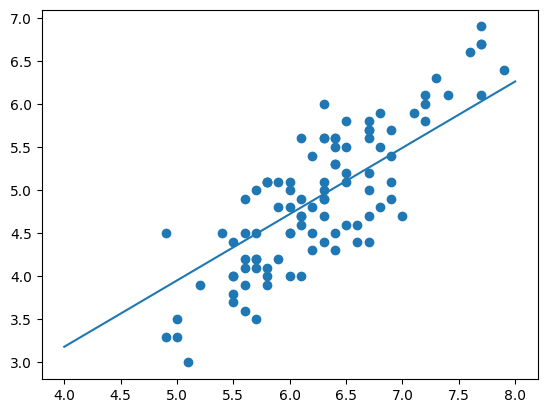

/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


63.8 ms ± 4.12 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Parameters: [0.10331655 0.76979253]


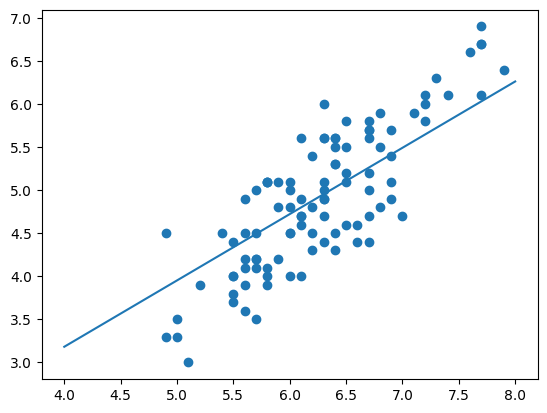

In [6]:
import numpy as np
import pandas as pd
import numba as nb
import math
from numba import cuda, jit, float32, int32
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import time
import matplotlib.pyplot as plt
# Linear regression function which is run on host:
def compute_parameter(x,y,learning_rate,theta):
    mat_x = np.array(x)
    mat_x = np.array(np.column_stack((np.ones((mat_x.shape[0],1)),mat_x)))
    mat_y = np.array(y)

    h_theta = np.matmul(mat_x,theta)
    diff = mat_y - h_theta

    for i in range(0,theta.shape[0]):
        theta[i]+=(learning_rate * np.matmul(diff.T,mat_x[:,i].reshape(x.shape[0],1))).reshape(1)
    return theta

def linear_regression_gd_cpu(x,y,learning_rate = 0.00001,max_iter=1000):
    theta = np.zeros((x.shape[1]+1,1))
    for i in range(max_iter):
        theta = compute_parameter(x,y,learning_rate,theta)
    return theta

# Linear regression function which is run on device:
@cuda.jit
def gradient_descent_kernel(x, y, learning_rate, theta, num_features):
    idx = cuda.grid(1)
    s_x = cuda.shared.array(shape=(BLOCK_SIZE, 2), dtype=float32)
    s_y = cuda.shared.array(shape=BLOCK_SIZE, dtype=float32)

    diff = 0.0

    if idx < x.shape[0]:
        s_y[cuda.threadIdx.x] = y[idx, 0]
        for i in range(num_features):
            s_x[cuda.threadIdx.x, i] = x[idx, i]
        cuda.syncthreads()

    if idx < x.shape[0]:
        hypothesis = 0.0
        for i in range(num_features):
            hypothesis += s_x[cuda.threadIdx.x, i] * theta[i]

        diff = hypothesis - s_y[cuda.threadIdx.x]

        for i in range(num_features):
            cuda.atomic.add(theta, i, -learning_rate * diff * s_x[idx, i])


def linear_regression_gd_gpu(x,y,learning_rate = 0.00001,max_iter=1000):
    # Modify x to have an extra column of 1 so we can use for bias term
    x = np.array(x)
    x = np.array(np.column_stack((np.ones((x.shape[0],1)),x)))
    x = np.float32(x)
    num_features = x.shape[1]

    theta = np.zeros(2, dtype=np.float32)
    x_d = cuda.to_device(x.astype(float))
    y_d = cuda.to_device(y.astype(float))
    theta_d = cuda.to_device(theta.astype(float))

    threads_per_block = 128
    blocks_per_grid = (x.shape[0] + threads_per_block - 1) // threads_per_block
    for i in range(max_iter):
        gradient_descent_kernel[blocks_per_grid, threads_per_block](x_d, y_d, learning_rate, theta_d, num_features)
    theta = theta_d.copy_to_host()
    return theta


# Data used for examining the computation speed is iris data
# Modifying it a bit and change its label to number
data_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'label']
data = pd.read_csv('iris.data', names = data_names)
sub_data = data.loc[data['label'] != 'Iris-setosa', :]
y = sub_data['petal_length'].values
x = sub_data['sepal_length'].values
x = x.reshape(-1,1)
y = y.reshape(-1,1)

# Analyze data iris on host
%timeit theta = linear_regression_gd_cpu(x,y)
theta = linear_regression_gd_cpu(x,y)
print('Parameters:',theta)
x_new = np.linspace(4,8)
y_new = np.add(np.multiply(theta[1],x_new),theta[0])
plt.scatter(x,y)
plt.plot(x_new,y_new)
plt.show()

# Analyze data iris on device
BLOCK_SIZE = 128
%timeit theta = linear_regression_gd_gpu(x,y)
theta = linear_regression_gd_gpu(x,y)
print('Parameters:',theta)
x_new = np.linspace(4,8)
y_new = np.add(np.multiply(theta[1],x_new),theta[0])
plt.figure()
plt.scatter(x,y)
plt.plot(x_new,y_new)
plt.show()